<a href="https://colab.research.google.com/github/mancher07/loxc/blob/master/SD3_jupyter_Master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>INDEPENDENCIAS</b>:

In [1]:
!pip install transformers torch accelerate

%cd /content
!git clone -b master https://github.com/camenduru/ComfyUI /content/MasterUI
%cd /content/MasterUI

!pip install torch numpy pillow
!pip install -q torchsde einops diffusers accelerate xformers==0.0.26.post1
!apt -y install -qq aria2

!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/adamo1139/stable-diffusion-3-medium-ungated/resolve/main/sd3_medium_incl_clips_t5xxlfp8.safetensors -d /content/MasterUI/model -o sd3_medium_incl_clips_t5xxlfp8.safetensors

import torch
import random
import node_helpers
from comfy.sd import load_checkpoint_guess_config
import nodes
import numpy as np
from PIL import Image
from google.colab import files
import matplotlib.pyplot as plt
import io
import IPython.display as display

with torch.inference_mode():
    model_patcher, clip, vae, clipvision = load_checkpoint_guess_config("/content/MasterUI/model/sd3_medium_incl_clips_t5xxlfp8.safetensors", output_vae=True, output_clip=True, embedding_directory=None)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 4.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

<b>STYLES:</b>

In [ ]:
prompt= "a greeting card for a inaugaration party of a hotel include  a greeting wish "

import torch
from transformers import GenerationConfig, GPT2LMHeadModel, GPT2Tokenizer, LogitsProcessor, LogitsProcessorList


styles = {
    "cinematic": "cinematic film still of {prompt}, highly detailed, high budget hollywood movie, cinemascope, moody, epic, gorgeous, film grain",
    "anime": "anime artwork of {prompt}, anime style, key visual, vibrant, studio anime, highly detailed",
    "photographic": "cinematic photo of {prompt}, 35mm photograph, film, professional, 4k, highly detailed",
    "comic": "comic of {prompt}, graphic illustration, comic art, graphic novel art, vibrant, highly detailed",
    "lineart": "line art drawing {prompt},highly detailed, professional, sleek, modern, minimalist, graphic, line art, vector graphics",
    "pixelart": " pixel-art {prompt}, low-res, blocky, pixel art style, 8-bit graphics",
    "surrealist": "surrealist artwork of {prompt}, dreamlike, bizarre, imaginative, highly detailed, surreal",
    "steampunk": "steampunk illustration of {prompt}, industrial, victorian, gears and cogs , highly detailed",
    "cartoon": "cartoon drawing of {prompt}, playful, colorful, animated style, fun, highly detailed",
    "impressionist": "impressionist painting of {prompt}, soft brush strokes, light and color, artistic, highly detailed",
    "fantasy": "fantasy artwork of {prompt}, magical, ethereal, highly detailed, imaginative, dreamlike",
    "minimalist": "minimalist illustration of {prompt}, clean lines, simple shapes, modern, elegant, highly detailed",
    "popart": "pop art illustration of {prompt}, bold colors, comic book style, high contrast, vibrant, graphic",
    "abstract": "abstract art of {prompt}, vibrant colors, geometric shapes, modern, artistic, highly detailed",
    "vintage": "vintage illustration of {prompt}, retro, nostalgic, sepia tones, highly detailed, classic",
    "watercolor": "watercolor painting of {prompt}, soft colors, dreamy, artistic, hand-painted, highly detailed",
}

words = [
    "aesthetic", "astonishing", "beautiful", "breathtaking", "composition", "contrasted", "epic", "moody", "enhanced",
    "exceptional", "fascinating", "flawless", "glamorous", "glorious", "illumination", "impressive", "improved",
    "inspirational", "magnificent", "majestic", "hyperrealistic", "smooth", "sharp", "focus", "stunning", "detailed",
    "intricate", "dramatic", "high", "quality", "perfect", "light", "ultra", "highly", "radiant", "satisfying",
    "soothing", "sophisticated", "stylish", "sublime", "terrific", "touching", "timeless", "wonderful", "unbelievable",
    "elegant", "awesome", "amazing", "dynamic", "trendy",
]

word_pairs = ["highly detailed", "high quality", "enhanced quality", "perfect composition", "dynamic light"]

def find_and_order_pairs(s, pairs):
    words = s.split()
    found_pairs = []
    for pair in pairs:
        pair_words = pair.split()
        if pair_words[0] in words and pair_words[1] in words:
            found_pairs.append(pair)
            words.remove(pair_words[0])
            words.remove(pair_words[1])

    for word in words[:]:
        for pair in pairs:
            if word in pair.split():
                words.remove(word)
                break
    ordered_pairs = ", ".join(found_pairs)
    remaining_s = ", ".join(words)
    return ordered_pairs, remaining_s

tokenizer = GPT2Tokenizer.from_pretrained("Gustavosta/MagicPrompt-Stable-Diffusion")
model = GPT2LMHeadModel.from_pretrained("Gustavosta/MagicPrompt-Stable-Diffusion", torch_dtype=torch.float16).to(
    "cuda"
)
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/912 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/510M [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
class CustomLogitsProcessor(LogitsProcessor):
    def __init__(self, bias):
        super().__init__()
        self.bias = bias

    def __call__(self, input_ids, scores):
        if len(input_ids.shape) == 2:
            last_token_id = input_ids[0, -1]
            self.bias[last_token_id] = -1e10
        return scores + self.bias

word_ids = [tokenizer.encode(word, add_prefix_space=True)[0] for word in words]
bias = torch.full((tokenizer.vocab_size,), -float("Inf")).to("cuda")
bias[word_ids] = 0
processor = CustomLogitsProcessor(bias)
processor_list = LogitsProcessorList([processor])

style = "surrealist"

prompt = styles[style].format(prompt=prompt)

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("Gustavosta/MagicPrompt-Stable-Diffusion")
model = GPT2LMHeadModel.from_pretrained("Gustavosta/MagicPrompt-Stable-Diffusion", torch_dtype=torch.float16).to(
    "cuda"
)
model.eval()

inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
token_count = inputs["input_ids"].shape[1]
max_new_tokens = 50 - token_count

generation_config = GenerationConfig(
    penalty_alpha=0.7,
    top_k=50,
    eos_token_id=model.config.eos_token_id,
    pad_token_id=model.config.eos_token_id,
    pad_token=model.config.pad_token_id,
    do_sample=True,
)

with torch.no_grad():
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_new_tokens=max_new_tokens,
        generation_config=generation_config,
        logits_processor=processor_list,
    )

output_tokens = [tokenizer.decode(generated_id, skip_special_tokens=True) for generated_id in generated_ids]
input_part, generated_part = output_tokens[0][: len(prompt)], output_tokens[0][len(prompt) :]
pairs, words = find_and_order_pairs(generated_part, word_pairs)
formatted_generated_part = pairs + ", " + words
enhanced_prompt = input_part + ", " + formatted_generated_part

In [ ]:
#initial_prompt = "A serene landscape with mountains and a lake at sunset."
model_name = "gpt2"  # You can use other models available on Hugging Face
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

def generate_improved_prompt(initial_prompt, model_name="gpt2", max_length=50):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)

    input_ids = tokenizer.encode(f"Improve the following image generation prompt: '{initial_prompt}'", return_tensors="pt")
    output = model.generate(input_ids, max_length=max_length, num_return_sequences=1, no_repeat_ngram_size=2)

    improved_prompt = tokenizer.decode(output[0], skip_special_tokens=True)
    return improved_prompt

# Generate an improved prompt using the function
improved_prompt = generate_improved_prompt(prompt, model_name)
print("Improved prompt:", improved_prompt)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Improved prompt: Improve the following image generation prompt:'surrealist artwork of a greeting card for a inaugaration party of a hotel include  a greeting wish, dreamlike, bizarre, imaginative, highly detailed, surreal'

The image is a


<b>SD3 INTERACTIVE</b>

1


  0%|          | 0/28 [00:00<?, ?it/s]

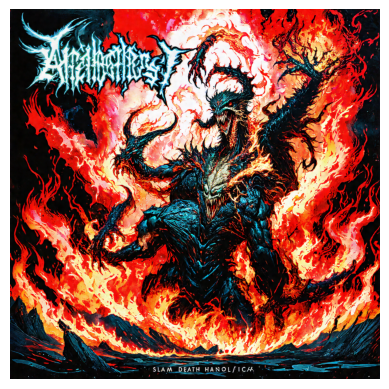


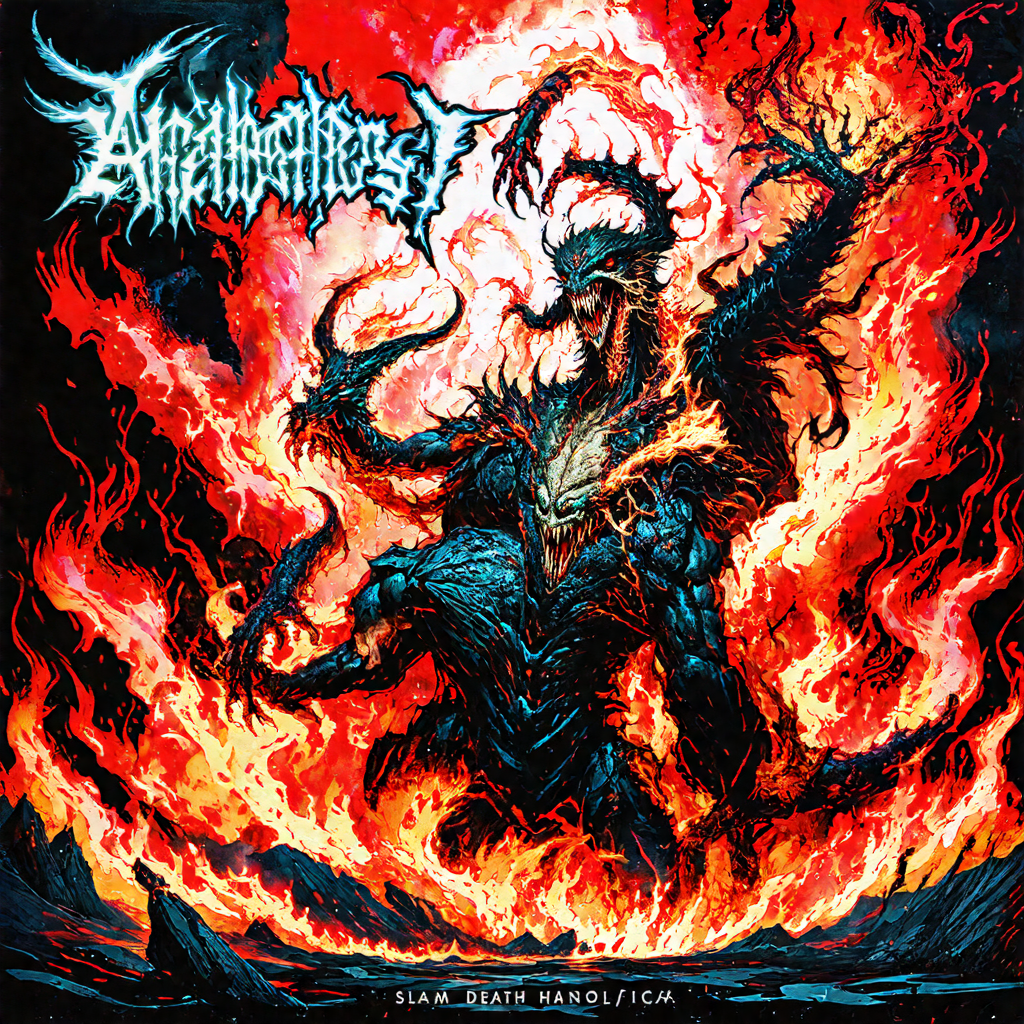

In [22]:
def zero_out(conditioning):
    c = []
    for t in conditioning:
        d = t[1].copy()
        if "pooled_output" in d:
            d["pooled_output"] = torch.zeros_like(d["pooled_output"])
        n = [torch.zeros_like(t[0]), d]
        c.append(n)
    return (c, )

with torch.inference_mode():
    latent = {"samples": torch.ones([1, 16, 1024 // 8, 1024 // 8]) * 0.0609}
    prompt = "Create a cover art of a chaotic, fiery hellscape teeming with grotesque entities and monstrous organisms, inspired by slam/death metal album aesthetics, with full detail and intensity."
    cond, pooled = clip.encode_from_tokens(clip.tokenize(prompt), return_pooled=True)
    cond = [[cond, {"pooled_output": pooled}]]
    negative_prompt = "bad quality, poor quality, doll, disfigured, jpg, toy, bad anatomy, missing limbs, missing fingers, 3d, cgi"
    n_cond, n_pooled = clip.encode_from_tokens(clip.tokenize(negative_prompt), return_pooled=True)
    n_cond = [[n_cond, {"pooled_output": n_pooled}]]

    n_cond1 = node_helpers.conditioning_set_values(n_cond, {"start_percent": 0, "end_percent": 0.1})
    n_cond2 = zero_out(n_cond)
    n_cond2 = node_helpers.conditioning_set_values(n_cond2[0], {"start_percent": 0.1, "end_percent": 1.0})
    n_cond = n_cond1 + n_cond2

    seed = 1
    if seed == 0:
        seed = random.randint(0, 18446744073709551615)
    print(seed)
    sample = nodes.common_ksampler(model=model_patcher,
                                   seed=95338002316328,
                                   steps=28,
                                   cfg=4.5,
                                   sampler_name="dpm_fast",
                                   scheduler="sgm_uniform",
                                   positive=cond,
                                   negative=n_cond,
                                   latent=latent,
                                   force_full_denoise="true",
                                   denoise=40)
    sample = sample[0]["samples"].to(torch.float16)
    vae.first_stage_model.cuda()
    decoded = vae.decode_tiled(sample).detach()

# Convert the tensor to a PIL Image
img = Image.fromarray(np.array(decoded * 255, dtype=np.uint8)[0])

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Save the image with high quality
img_path = '/content/output_image.png'
img.save(img_path, format="PNG", quality=100)

# Create a HTML button for download
def create_download_button(file_path):
    from IPython.display import HTML
    import base64

    # Read the image and encode it in base64
    with open(file_path, 'rb') as f:
        data = f.read()
    b64_data = base64.b64encode(data).decode()

    # Create the HTML element
    html_code = f'''
    <a download="{file_path.split('/')[-1]}" href="data:image/png;base64,{b64_data}" target="_blank">
        <button style="padding:10px; font-size:15px;">Descargar Imagen</button>
    </a>
    '''
    display.display(HTML(html_code))

create_download_button(img_path)